In [178]:
import tensorflow
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [179]:
import os
#deleting the file if it already exists
if(os.path.exists("socialmedia_relevant_cols_clean.csv")):
    os.remove("socialmedia_relevant_cols_clean.csv")
    print("Deleted previous file")
input_file = codecs.open("train.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv","w", encoding='utf-8')

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
    output_file.close()
sanitize_characters(input_file, output_file)
output_file.close()

Delete previous file


In [180]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [181]:
questions.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [182]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")
if(os.path.exists("clean_data.csv")):
    os.remove("clean_data.csv")
questions.to_csv("clean_data.csv")
questions.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


In [183]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.groupby("target").count()

,Unnamed: 0,id,keyword,location,text
target,,,,,
0,4342,4342,4323,2884,4342
1,3271,3271,3229,2196,3271


In [184]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,id,keyword,location,text,target,tokens
0,0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,3,6,NaN,NaN,"13,000 people receive wildfires evacuation or...",1,"[13, 000, people, receive, wildfires, evacuati..."
4,4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


In [185]:
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

108242 words total, with a vocabulary size of 14754
Max sentence length is 34


In [186]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

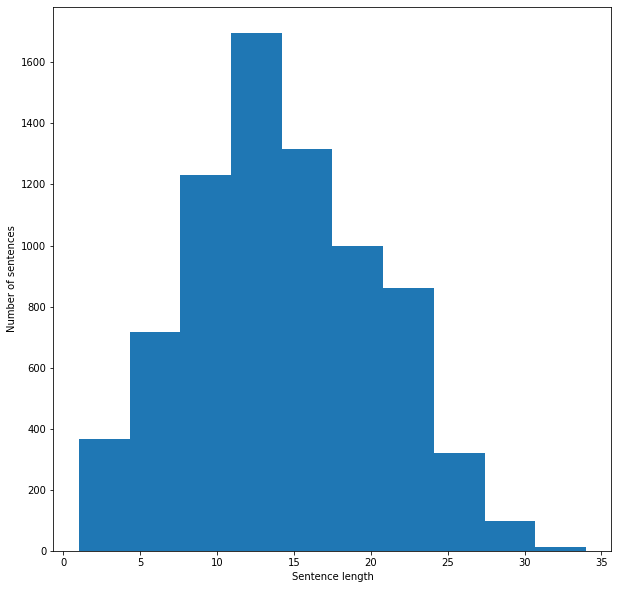

In [187]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [328]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data) #emb stores a matrix of token count   

    return emb, count_vectorizer   #count_vectorizer stores features and can be accessed using count_vectorizer.get_feature_names()

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)
len(X_train_counts.toarray())  #2d array of size n * 13981  where n is the size of input
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html for reference

6090

In [329]:
#print(X_train_counts)

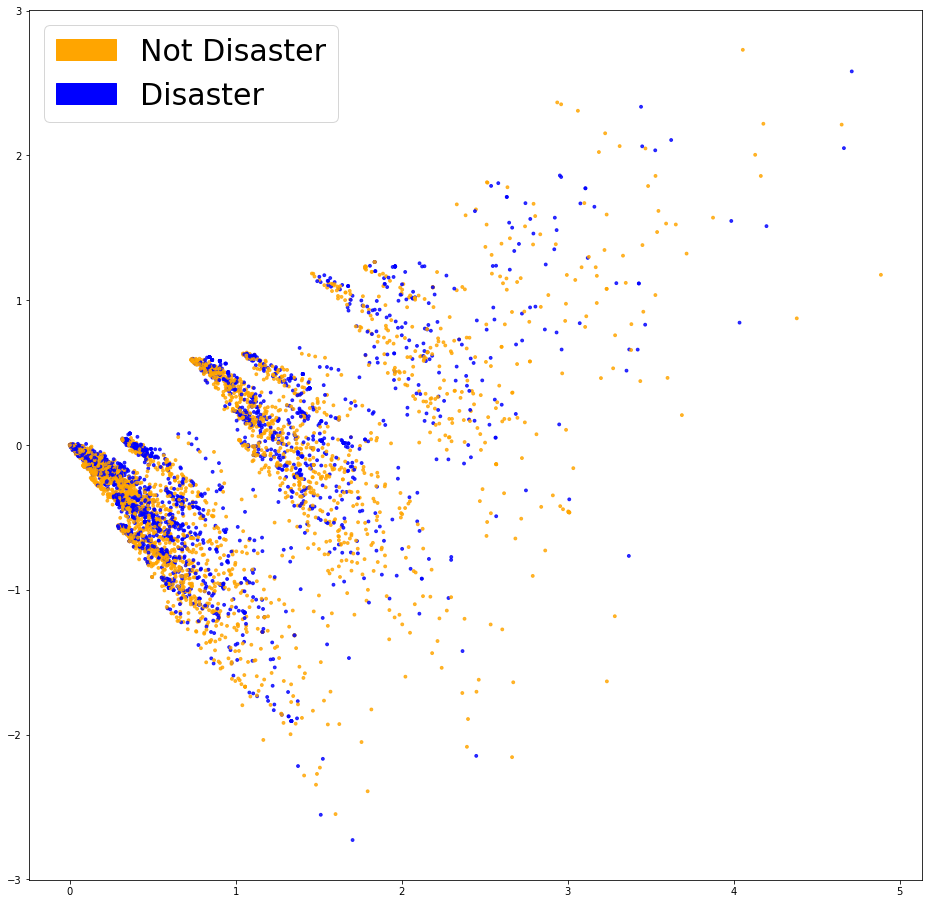

In [330]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

#In the following code we have tried to reduce the dimensions from 13,000 to 2 for the purpose of representation

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        #print(test_data)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        #print(lsa_scores)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        #print(set(test_labels))
        color_column = [color_mapper[label] for label in test_labels]
        #print(color_column)
        colors = ['orange','blue']
        if plot:
            #How does the following function i.e scatter() work?
            #lsa_scores[:,0] & lsa_scores[:,1] serve as the value of the x-axis & y-axis respectively.
            #s is marker size, alpha controls balance between opacity and transparency
            #c is a scalar or sequence of n numbers to be mapped to colors using cmap
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Not Disaster')
            #print(red_patch)
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))
#print(y_train)
plot_LSA(X_train_counts, y_train)
plt.show()

In [331]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [332]:
#In the below code, the concept of precision and recall comes into play!
#We have to choose optimum value of recall and precision as we can afford to have a non-disaster tweet classified as disaster but not the other way
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.789, precision = 0.788, recall = 0.789, f1 = 0.788
